# Intermediate Jaxloop Usage

The objective of this notebook is to cover more features of Jaxloop (go/jaxloop). For introductory usage, see the [Getting Started Colab](https://colab.corp.google.com/google_src/files/head/depot/google3/third_party/py/jaxloop/notebooks/Jaxloop_Quick_Start.ipynb).

We'll solve a straightforward classification problem (identifying handwritten digits). The **Dataset**, **Modeling**, and **Loss function** sections cover the ML solution (a CNN optimizing softmax cross entropy loss).

> This example builds on a solution [from Flax docs](https://flax.readthedocs.io/en/v0.6.11/getting_started.html).

See the **Training** section for the custom training loop (CTL) implemenation using Jaxloop. It includes a [custom Action](#scrollTo=XCtoZ3gS8Iyk) that aggregates and records training metrics every epoch.

🛟 See go/jaxloop-support if you need to contact us.

## Running this Colab

▶️ You can start and connect to a "Jaxloop Documentation" Borg runtime (Google internal) to execute this notebook.

## Dataset & Modeling (click to expand)

We'll work with the well-known MNIST dataset, downloaded using [TensorFlow Datasets](https://www.tensorflow.org/datasets) (TFDS). The `get_datasets` function below gets, shuffles, and batches training and evaulation splits.

In [ ]:
# (Batched) data-loading utility

import tensorflow as tf
import tensorflow_datasets as tfds

def get_datasets(batch_size):
  """Load MNIST train and test datasets into memory."""
  train_ds = tfds.load('mnist', split='train')
  test_ds = tfds.load('mnist', split='test')

  # split the sets, convert the samples to floating-point numbers, and normalize
  train_ds = train_ds.map(lambda sample: {'image': tf.cast(sample['image'],
                                                           tf.float32) / 255.,
                                          'label': sample['label']})
  test_ds = test_ds.map(lambda sample: {'image': tf.cast(sample['image'],
                                                         tf.float32) / 255.,
                                        'label': sample['label']})

  # Shuffle datasets by allocating a buffer size of 1024 to randomly draw from
  # group into batches of batch_size and skip incomplete batch;
  # Prefetch the next sample to improve latency
  train_ds = train_ds.repeat().shuffle(1024)
  train_ds = train_ds.batch(batch_size, drop_remainder=True).prefetch(1)
  test_ds = test_ds.shuffle(1024)
  test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

  return train_ds, test_ds

For our model architecture, we use [Flax Linen](https://flax-linen.readthedocs.io/en/latest/index.html) to define a convolutional neural network (CNN) with two hidden layers.

In [ ]:
# Modeling (Linen)

from flax import linen as nn

class CNN(nn.Module):
  """A simple CNN model"""

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)
    return x

cnn = CNN()

### Custom train state

We customize the base `TrainState` class to add accuracy and loss metrics from [CLU](https://github.com/google/CommonLoopUtils/blob/main/clu/metrics.py) (as per the [Flax tutorial](https://flax.readthedocs.io/en/v0.6.11/getting_started.html) this notebook is based on).

> In Jaxloop, we could alternatively pass around metrics via the output of the Step's [`run` method](http://google3/third_party/py/jaxloop/step.py;l=296?q=run).

In [ ]:
# Custom train state (CTS)

# import jax.numpy as jnp
from clu import metrics
from flax import struct
from flax.training import train_state
from jaxloop import step
from jaxloop import types
from typing import Any, Optional

@struct.dataclass  # makes it compatible with JAX transformations
class Metrics(metrics.Collection):
  accuracy: metrics.Accuracy
  loss: metrics.Average.from_output('loss')

class CutsomTrainState(train_state.TrainState):
  metrics: Metrics = Metrics.empty()

class TrainStateType(CutsomTrainState):
  batch_stats: Optional[Any] = None

# Monkey-patch (types and) step with our CTS
types.TrainState = CutsomTrainState
step.State = TrainStateType

### Loss function

We define a `training_loss` function. It uses softmax cross entropy loss (good for multi-class classification tasks) from [Optax](https://github.com/google-deepmind/optax) to evaluate the gradients for a training batch. It then applies these gradients to the model state, updating its parameters. The `loss` value is returned (to update our custom state's metrics).

> Note: We do not need to JIT this function because it will run inside a Jaxloop `Step`, whose `run` method is jitted internally.

In [ ]:
import jax
import optax

def training_loss(
    state: types.TrainState,
    batch
):
  """Apply the model, compute loss, and apply gradients."""

  def _loss_fn(params, batch):
    logits = state.apply_fn({'params': params}, batch['image'])
    loss = optax.softmax_cross_entropy_with_integer_labels(
      logits=logits, labels=batch['label']).mean()
    return loss

  grad_fn = jax.value_and_grad(_loss_fn)
  loss, grads = grad_fn(state.params, batch)
  state = state.apply_gradients(grads=grads)

  return state, loss

The `compute_metrics` function below calculates the model's metrics. `loss` uses softmax cross entropy (to remain consistent), and `accuracy` is implicitly obtained in `single_from_model_output` (from CLU metrics).

In [ ]:
# Metrics computation

@jax.jit
def compute_metrics(*, state, batch):
  logits = state.apply_fn({'params': state.params}, batch['image'])
  loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
  metric_updates = state.metrics.single_from_model_output(
    logits=logits, labels=batch['label'], loss=loss)
  metrics = state.metrics.merge(metric_updates)
  state = state.replace(metrics=metrics)
  return state

## Training

First we set relevant hyperparameters and start a random number generator for JAX. Then we obtain the dataset training and testing splits.

In [ ]:
# Hyperparams

rng_seed = 0
batch_size = 32
learning_rate = 0.001
steps_per_epoch = 125
num_train_steps = 1250

In [ ]:
# Download data splits & set more vars
from jax.random import PRNGKey

prng = PRNGKey(rng_seed)

train_ds, test_ds = get_datasets(batch_size)

# Util for printing metrics periodically (stdout)
metrics_history = {}

### Training Step

Now that the stage is set, that is, we have a dataset and modeling strategy ready, we can turn to Jaxloop for the actual training.

We start by defining a training step ([`jaxloop.Step`](http://go/jaxloop-api#core-loops-and-step) class with `run` function), which represents the per-batch routine to update the model parameters. In this case we rely on the previously defined loss function, but reformat the `output` as a standard dictionary.

To instantiate the `train_step`, we provide our RNG, CNN model, an optimizer, and specify the `train=True` flag.

> Skipping that last bit would create a testing or evaluation step. While typical, we can technically skip evaluation and still get good results for this well-known ML problem.

In [ ]:
# Define Train steps

from jaxloop import step
from typing import Tuple

class Step(step.Step):
  def run(
    self, state: step.State, batch: step.Batch
  ) -> Tuple[step.State, step.Output]:
    """Get loss (and apply gradients if training)."""

    # if self._train:
    state, loss = training_loss(state, batch)
    # else:
    #   state, loss = eval_loss(state, batch)

    state = compute_metrics(state=state, batch=batch) # aggregate metrics

    output = {
        "loss": loss,
    }

    return state, output

train_step = Step(
  base_prng=prng,
  model=cnn,
  optimizer=optax.adam(learning_rate),
  train=True,
)

### Custom Action (callback)

We are going to create a [Jaxloop action](http://go/jaxloop-actions) to record metrics summaries every training epoch. To do so, we extend the `actions.Action` class and overwrite its `__call__` method. This uses the [custom](#scrollTo=yi103DjkNnnH) train `state` defined earlier. We instantiate the action as `record_metrics`.

> Note that this step is optional and does not affect model training.

In [ ]:
# Define Action to record metrics periodically

from jaxloop import actions

class RecordMetrics(actions.Action):
  def __call__(
      self, state: types.TrainState, outputs: Optional[types.Output], **kwargs
  ) -> None:
    for metric,value in state.metrics.compute().items(): # Compute metrics (loss, accuracy)
      train_metric_name = f'train_{metric}'
      if train_metric_name not in metrics_history:
         metrics_history[train_metric_name] = []
      metrics_history[train_metric_name].append(value)   # and record them;
    state = state.replace(metrics=state.metrics.empty()) # Reset them for next epoch

    test_state = state
    step = state.step
    num_steps_per_epoch = steps_per_epoch

    for test_batch in test_ds.as_numpy_iterator():
      test_state = compute_metrics(state=test_state, batch=test_batch)

    for metric,value in test_state.metrics.compute().items():
      test_metric_name = f'test_{metric}'
      if test_metric_name not in metrics_history:
         metrics_history[test_metric_name] = []
      metrics_history[test_metric_name].append(value)

    print(f"train epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['train_loss'][-1]}, "
          f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
    print(f"test epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")

record_metrics = RecordMetrics()

### Loops

Having created our batch training routine (`training_step`) and an action to log metrics, we come to the point of having to stitch them together into a larger training loop. Jaxloop will take care of this, and know when to execute train steps on each batch of data vs. callback actions at the appropriate time (in this case after each epoch).

Jaxloop separates inner loops (`train_loop`, `eval_loop`), which take train/eval steps and actions, from the `outer_loop`, which accept the train and eval loops themselves.

In [ ]:
# Define loops

from jaxloop import outer_loop
from jaxloop import train_loop

# Inner loop (epochs)
training = train_loop.TrainLoop(
  train_step,
  end_actions=[record_metrics]
)

# Outer loop (training)
ctl = outer_loop.OuterLoop(training)

### Execution

To run the training loop, we call our outer loop object (`ctl`). It takes a train state (which we instantiate first), a dataset iterator, and information to determine how many steps to run per loop and overall (defined earlier along with the hyperparams).

> When using testing steps, provide also an `eval_spec`.

In [ ]:
# Init model & get train state
batch_spec = train_ds.element_spec["image"].shape.as_list()  # [32, 28, 28, 1]
train_state = train_step.initialize_model(batch_spec)

# Start the loop!
train_state, _ = ctl(
  train_state,
  train_dataset=train_ds.as_numpy_iterator(),
  train_total_steps=num_train_steps,
  train_loop_steps=steps_per_epoch,
)

train epoch: 1, loss: 0.5348041653633118, accuracy: 84.32499694824219
test epoch: 1, loss: 0.24215184152126312, accuracy: 92.87860107421875
train epoch: 2, loss: 0.35458528995513916, accuracy: 89.7249984741211
test epoch: 2, loss: 0.17693790793418884, accuracy: 94.25080108642578
train epoch: 3, loss: 0.27574414014816284, accuracy: 92.0
test epoch: 3, loss: 0.10345719754695892, accuracy: 96.94511413574219
train epoch: 4, loss: 0.2302173376083374, accuracy: 93.25
test epoch: 4, loss: 0.08532088994979858, accuracy: 97.35577392578125
train epoch: 5, loss: 0.19929930567741394, accuracy: 94.15499877929688
test epoch: 5, loss: 0.07905904948711395, accuracy: 97.61618041992188
train epoch: 6, loss: 0.17818467319011688, accuracy: 94.80833435058594
test epoch: 6, loss: 0.08178248256444931, accuracy: 97.30569458007812
train epoch: 7, loss: 0.16115152835845947, accuracy: 95.30714416503906
test epoch: 7, loss: 0.08087555319070816, accuracy: 97.40585327148438
train epoch: 8, loss: 0.14854411780834198

Now that the model is trained, we can use the custom metrics we logged (via our custom action) to plot the training progress. The Loss should decrease as the accuracy increases.

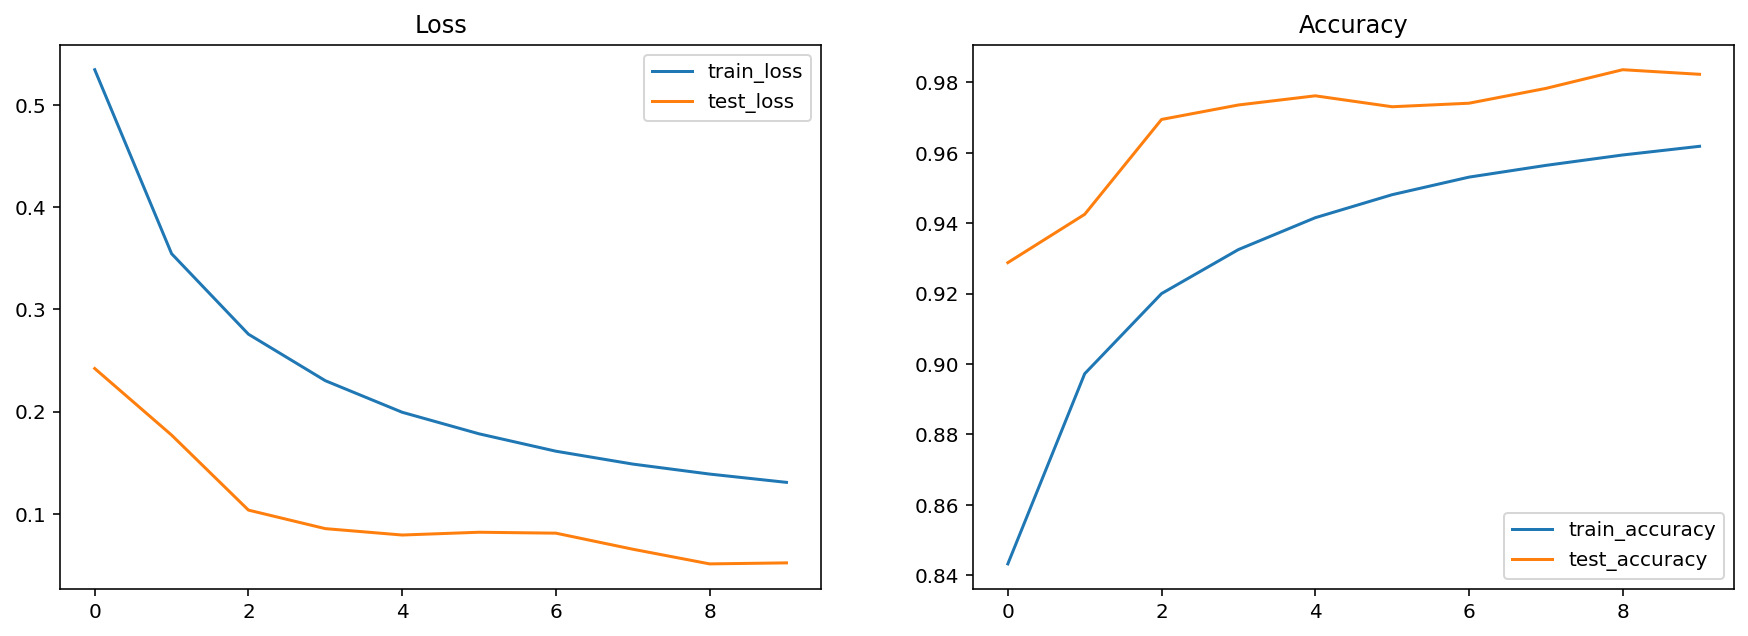

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot metrics history

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

## Results

Another way to visualize the results is to print out a random set of digit images from our dataset along with the label that our trained model assigns them.

In [ ]:
import jax

@jax.jit
def pred_step(state, batch):
  logits = state.apply_fn({'params': state.params}, test_batch['image'])
  return logits.argmax(axis=1)

test_batch = test_ds.as_numpy_iterator().next()
pred = pred_step(train_state, test_batch)

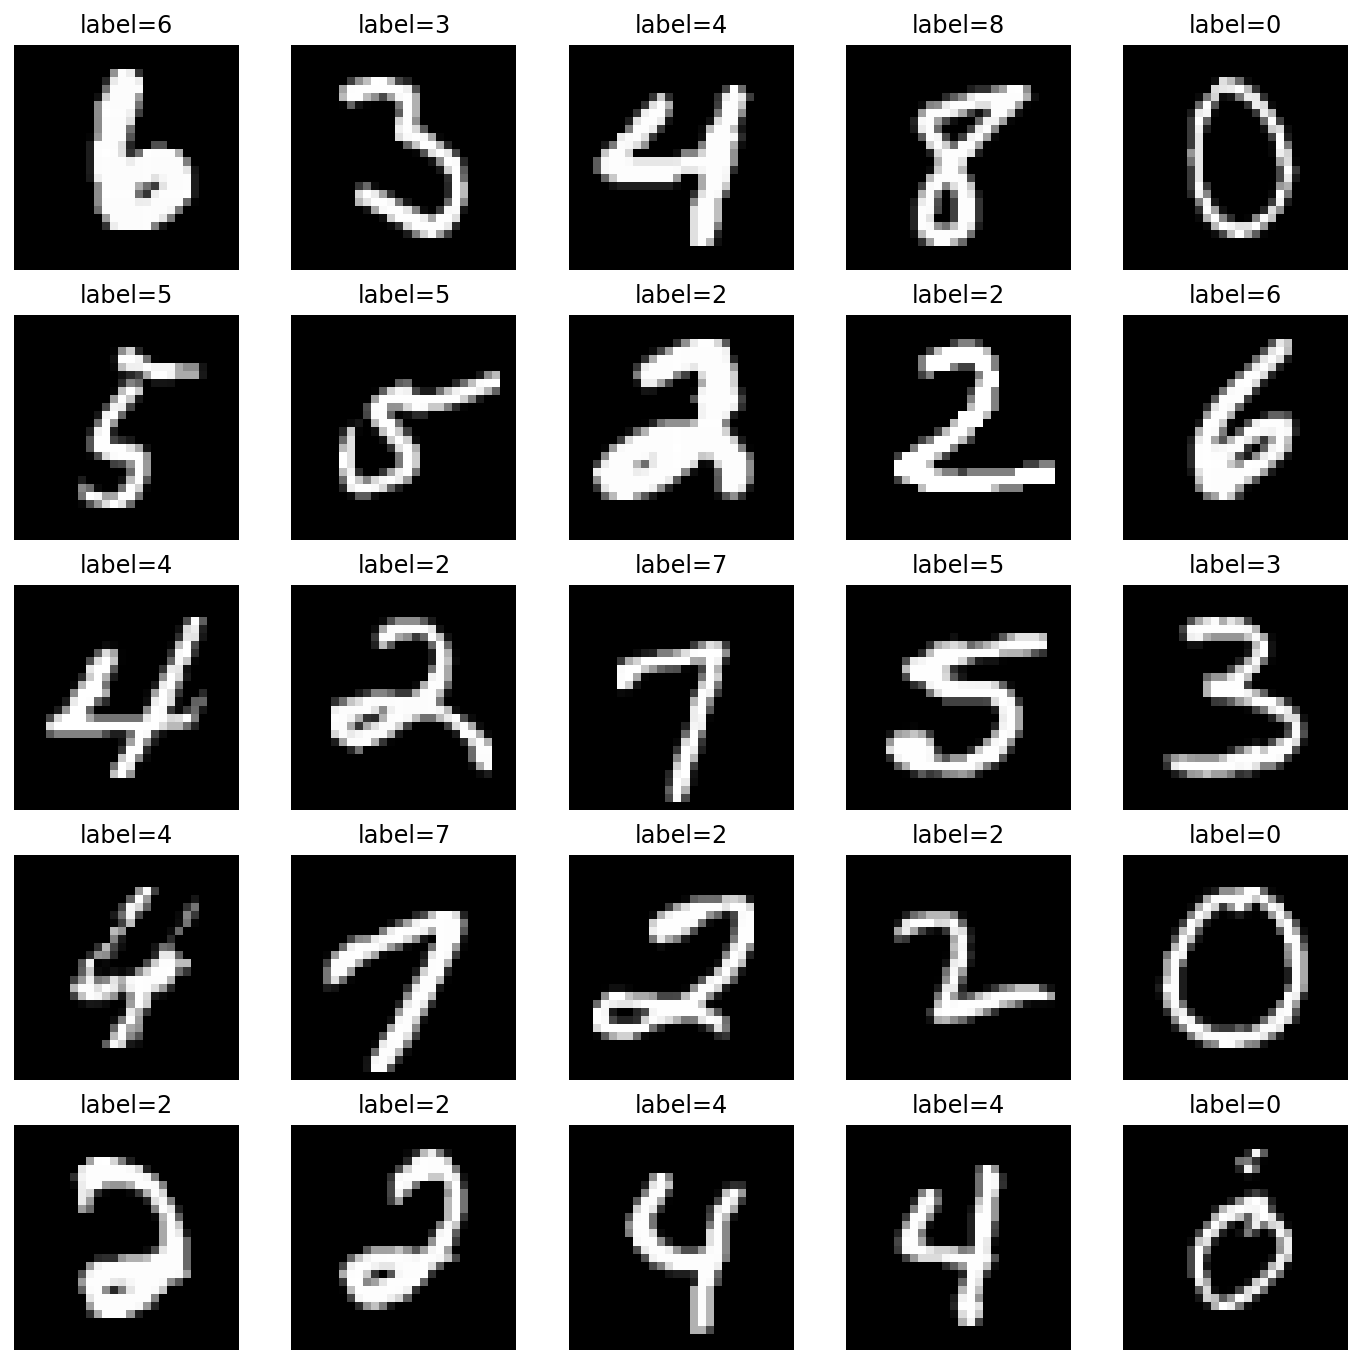

In [ ]:
# Visualization

import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(test_batch['image'][i, ..., 0], cmap='gray')
    ax.set_title(f"label={pred[i]}")
    ax.axis('off')

## More resources

For more advanced Jaxloop topics, see the [Actions](http://go/jaxloop-actions) information, and [API Overview](http://go/jaxloop-api).